# Vietnam Population — Bivariate map (Matplotlib + bivario)

This notebook demonstrates a bivariate choropleth using `bivario`, similar to `matplotlib.ipynb`, on Vietnam H3 population data.

Note: The sample uses `population` for both variables (diagonal bivariate). Replace `value_a`/`value_b` with your actual pair when available.


In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

from bivario import get_bivariate_cmap
from bivario._alpha import prepare_alpha_values
from bivario._scheme import apply_mapclassify
from bivario.legend import plot_bivariate_legend

DATA_PATH =   "./vn_pop_h3_8.shp"

gdf = gpd.read_file(DATA_PATH)

value_a = "population"
value_b = "hospital"

gdf.head()


,fid,h3,population,center_lat,center_lon,hospital,school,geometry
0,9103890,8869a9d727fffff,2.0,8.847453,112.192316,0.0,0.0,"POLYGON ((112.19625 8.84443, 112.19171 8.84243..."
1,9103891,8869a9d549fffff,1.0,8.846426,112.200788,0.0,0.0,"POLYGON ((112.20472 8.8434, 112.20018 8.8414, ..."
2,9103892,8869a9d469fffff,1.0,8.873495,112.229869,0.0,0.0,"POLYGON ((112.2338 8.87047, 112.22926 8.86847,..."
3,9103893,8869a9d407fffff,8.0,8.862358,112.258592,0.0,0.0,"POLYGON ((112.26252 8.85933, 112.25798 8.85733..."
4,9103894,8869a9d401fffff,18.0,8.870408,112.255275,0.0,0.0,"POLYGON ((112.2592 8.86738, 112.25466 8.86538,..."


CRSError: The EPSG code is unknown. PROJ: proj_create_from_database: Cannot find proj.db

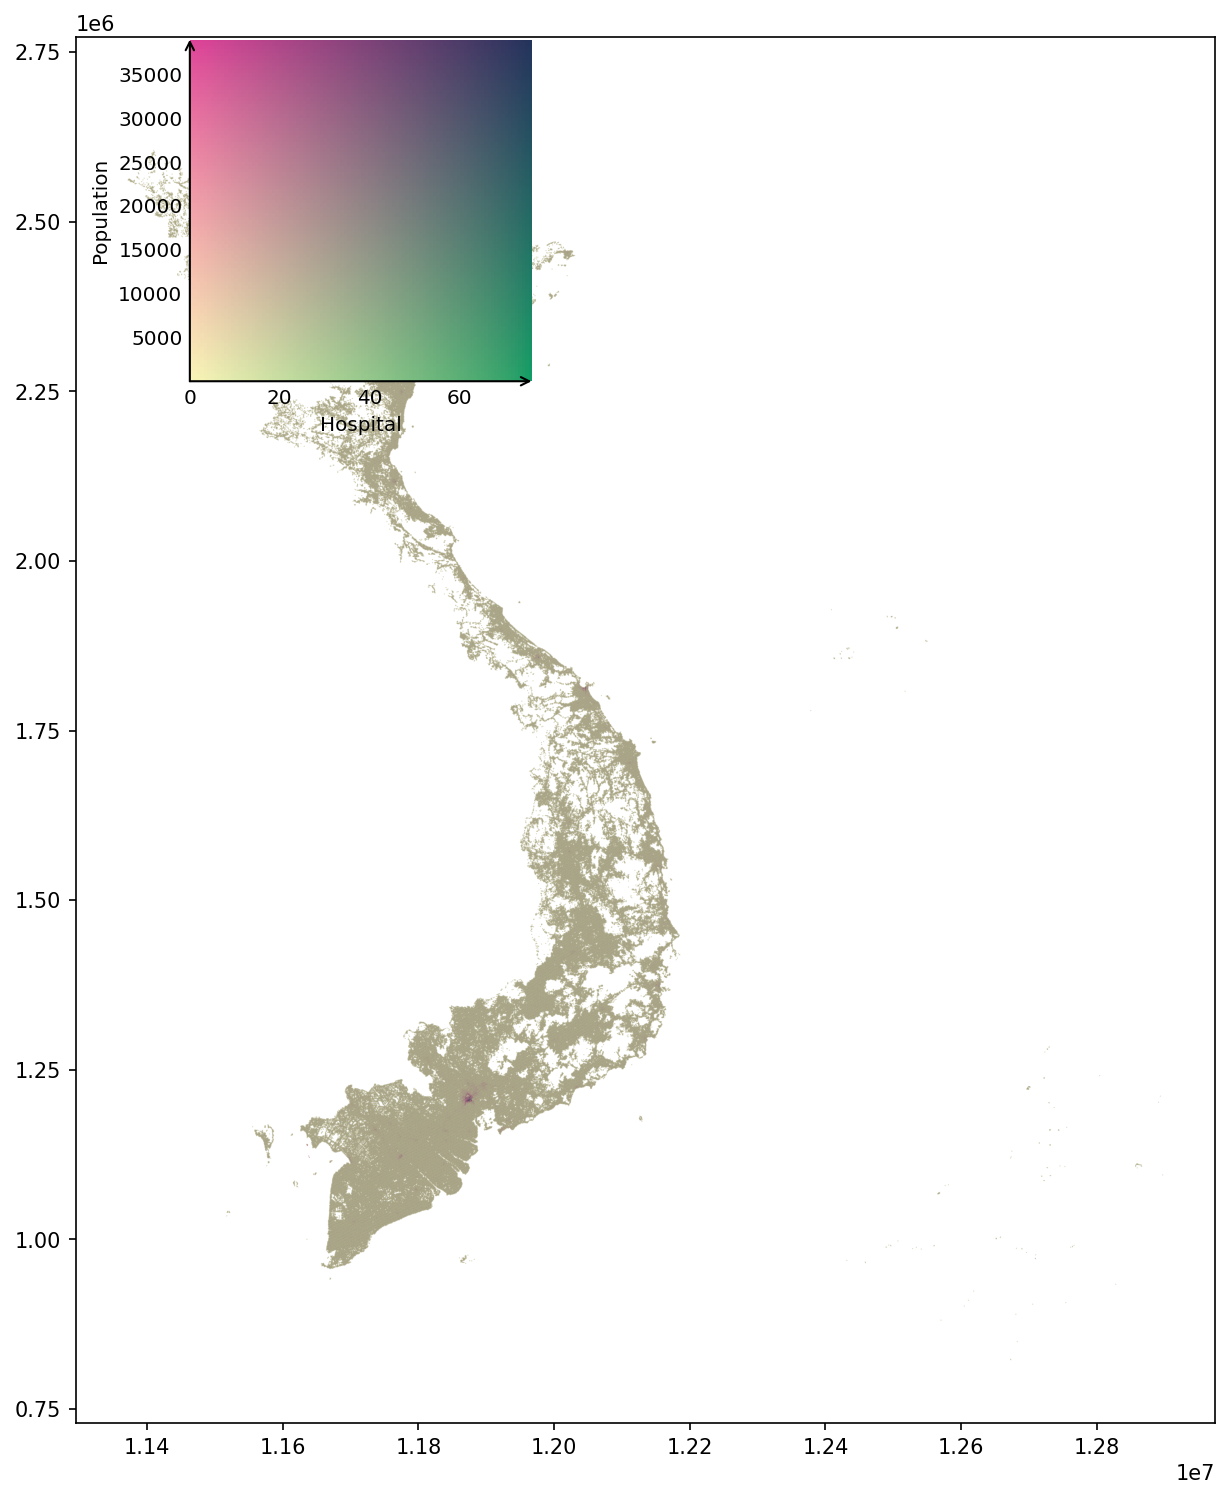

In [10]:
# Raw numerical bivario colours with inset legend

cmap = get_bivariate_cmap()
colours = cmap(gdf[value_a], gdf[value_b])

fig, ax = plt.subplots(figsize=(12, 12), dpi=150)

gdf.to_crs(epsg=3857).plot(
    color=colours,
    ax=ax,
)

gdf.to_crs(epsg=3857).boundary.plot(ax=ax, color="black", linewidth=0.3, alpha=0.1)

# Inset legend placement (similar to reference notebook)
inset_width = 0.3
inset_height = 0.25
x0 = 0.1
y0 = 1 - inset_height
inset_pos = [x0, y0, inset_width, inset_height]

inset_coords = ax.transAxes.transform(inset_pos[:2])
inset_size = ax.transAxes.transform([inset_width, inset_height]) - ax.transAxes.transform([0, 0])
fig_coords = fig.transFigure.inverted().transform(inset_coords)
fig_size = fig.transFigure.inverted().transform(inset_size + inset_coords) - fig_coords

legend_ax = fig.add_axes((*fig_coords, *fig_size))
plot_bivariate_legend(
    gdf[value_a],
    gdf[value_b],
    ax=legend_ax,
    cmap=cmap,
    label_a=value_a.replace("_", " ").title(),
    label_b=value_b.replace("_", " ").title(),
    tick_fontsize_px=20,
)

cx.add_basemap(ax, crs="EPSG:3857", source=cx.providers.CartoDB.PositronNoLabels)
ax.set_axis_off()
ax.set_title("Vietnam: Bivariate map (raw values)")
plt.tight_layout()
plt.show()


In [6]:
# Binning with mapclassify and alpha

alpha_values = prepare_alpha_values(gdf[value_a], gdf[value_b])

binning_result = apply_mapclassify(gdf[value_a], gdf[value_b])

cmap_dark = get_bivariate_cmap("glacier_ember", dark_mode=True)
binned_colours = cmap_dark(binning_result.values_a, binning_result.values_b)


CRSError: The EPSG code is unknown. PROJ: proj_create_from_database: Cannot find proj.db

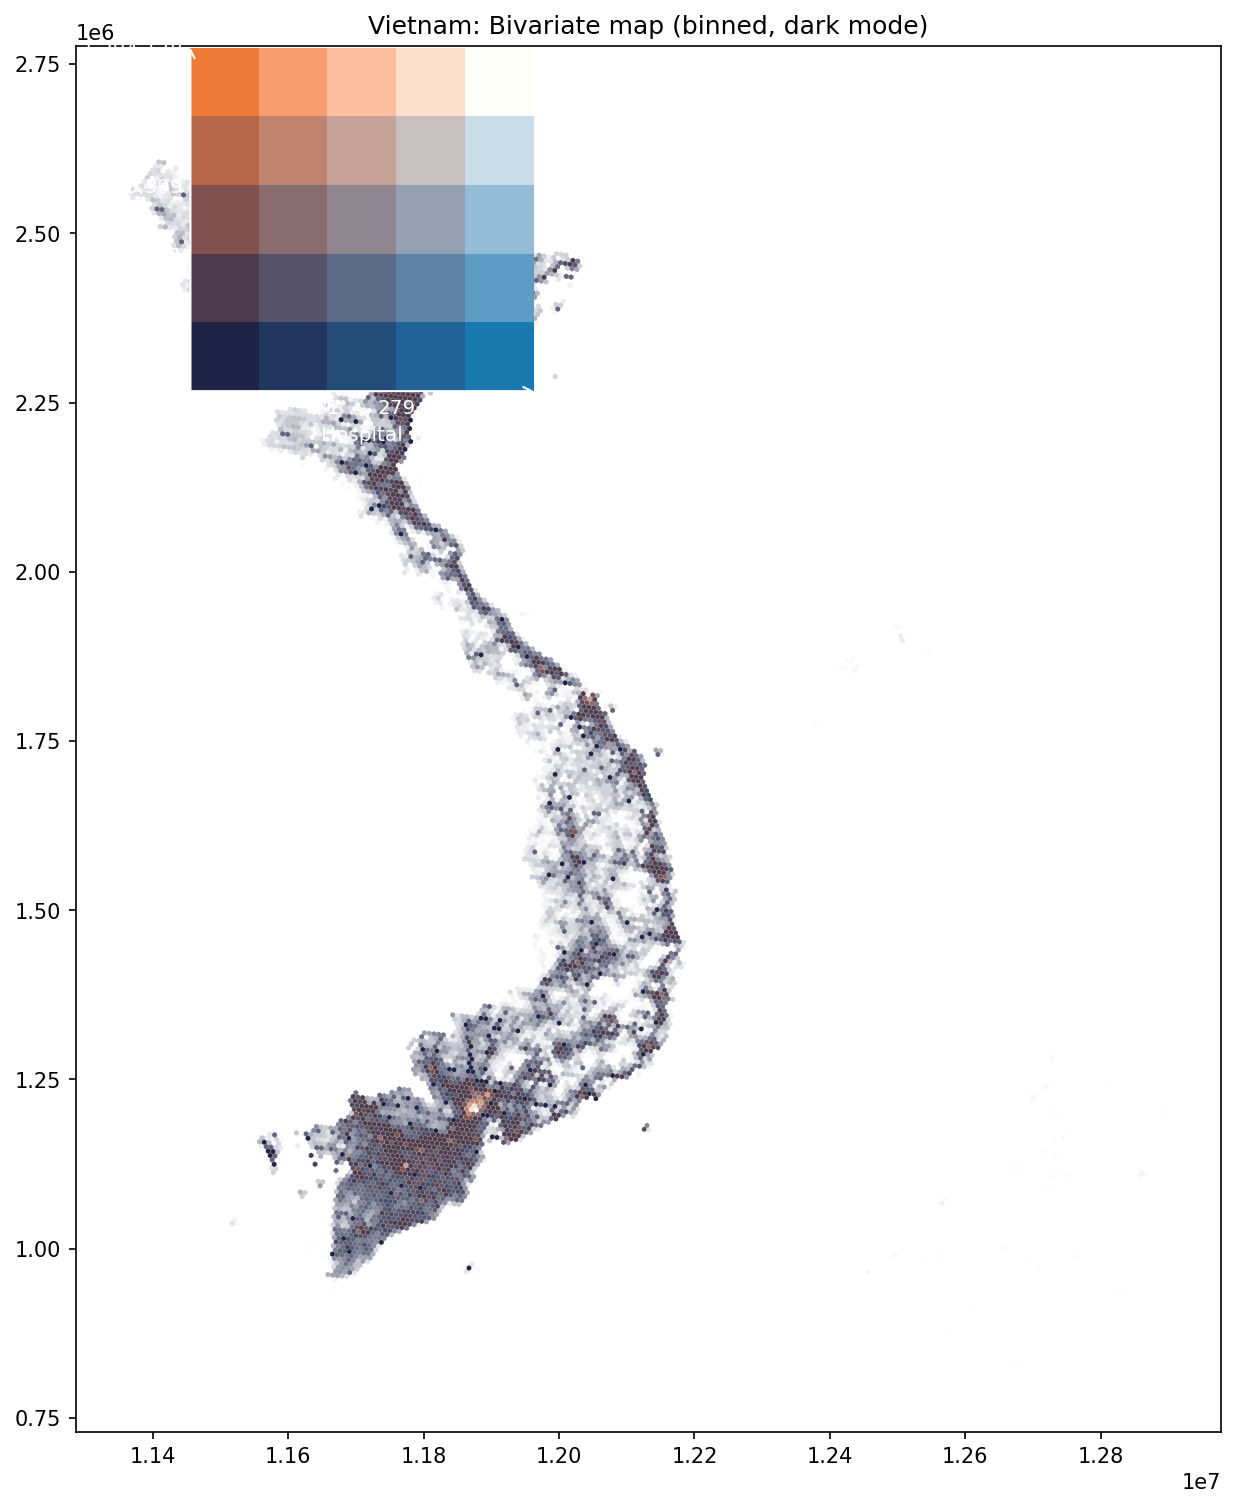

In [7]:
# Dark mode bivariate map with legend

fig, ax = plt.subplots(figsize=(12, 12), dpi=150)

plot_gdf = gdf.to_crs(epsg=3857)
plot_gdf.plot(
    color=binned_colours,
    alpha=alpha_values,
    ax=ax,
)

plot_gdf.boundary.plot(ax=ax, color="white", linewidth=0.3, alpha=0.1 * alpha_values)

# Legend grid sizes from binning result
grid_size_x = binning_result.k_b  # second variable -> X axis
grid_size_y = binning_result.k_a  # first variable  -> Y axis

# Inset legend (dark mode)
inset_width = 0.3
inset_height = 0.25
x0 = 0.1
y0 = 1 - inset_height
inset_pos = [x0, y0, inset_width, inset_height]

inset_coords = ax.transAxes.transform(inset_pos[:2])
inset_size = ax.transAxes.transform([inset_width, inset_height]) - ax.transAxes.transform([0, 0])
fig_coords = fig.transFigure.inverted().transform(inset_coords)
fig_size = fig.transFigure.inverted().transform(inset_size + inset_coords) - fig_coords

legend_ax = fig.add_axes((*fig_coords, *fig_size))
plot_bivariate_legend(
    gdf[value_a],
    gdf[value_b],
    ax=legend_ax,
    cmap=cmap_dark,
    label_a=value_a.replace("_", " ").title(),
    label_b=value_b.replace("_", " ").title(),
    tick_labels_a=binning_result.tick_labels_a,
    tick_labels_b=binning_result.tick_labels_b,
    grid_size=(grid_size_x, grid_size_y),
    tick_fontsize_px=20,
    dark_mode=True,
)

ax.set_title("Vietnam: Bivariate map (binned, dark mode)")
cx.add_basemap(ax, crs=plot_gdf.crs, source=cx.providers.CartoDB.DarkMatterNoLabels)
ax.set_axis_off()
plt.tight_layout()
plt.show()


CRSError: The EPSG code is unknown. PROJ: proj_create_from_database: Cannot find proj.db

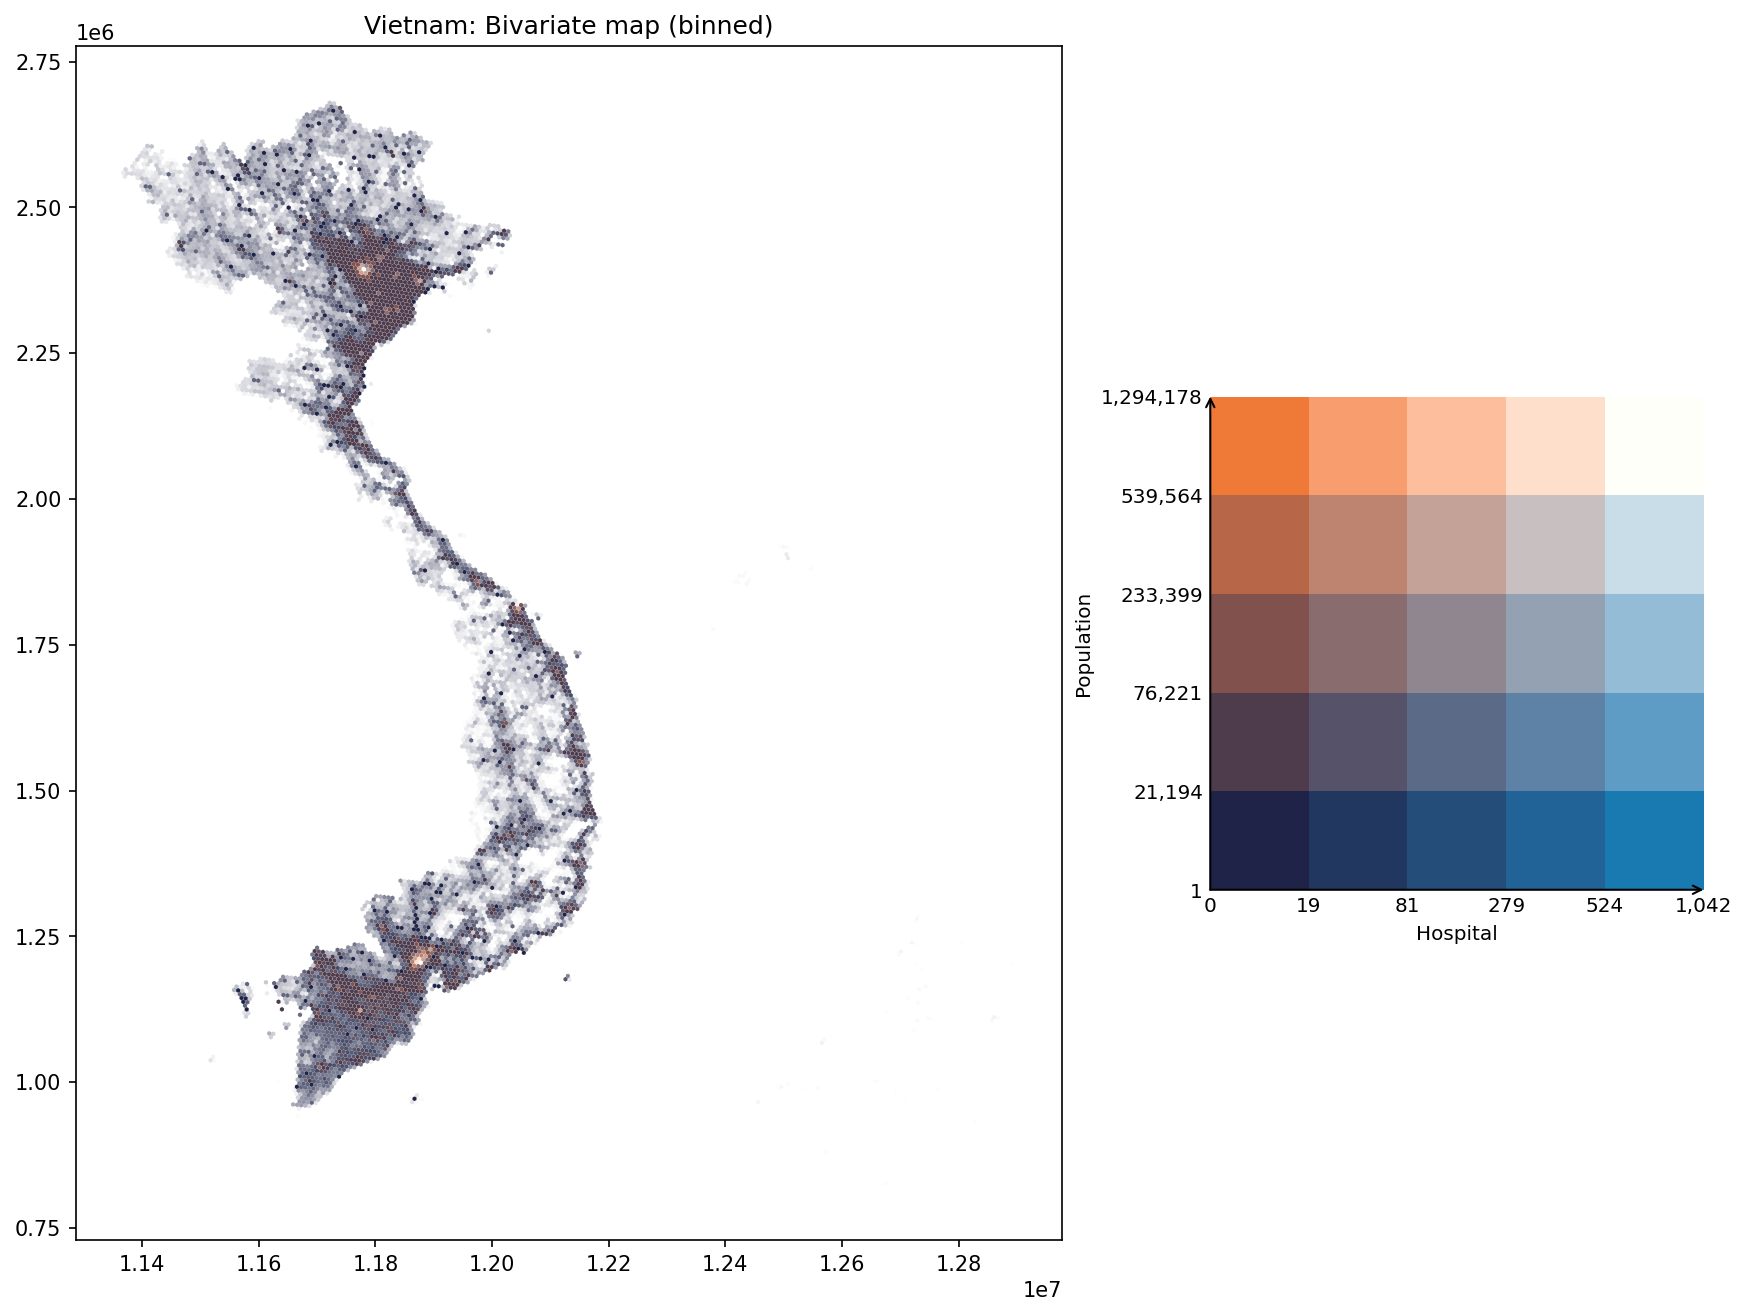

In [8]:
# Side-by-side legend layout

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 12), dpi=150, width_ratios=[2, 1])

plot_gdf = gdf.to_crs(epsg=3857)
plot_gdf.plot(
    color=binned_colours,
    alpha=alpha_values,
    ax=ax1,
)

plot_gdf.boundary.plot(ax=ax1, color="white", linewidth=0.3, alpha=0.1 * alpha_values)

# Legend on the right
plot_bivariate_legend(
    gdf[value_a],
    gdf[value_b],
    ax=ax2,
    cmap=cmap_dark,
    label_a=value_a.replace("_", " ").title(),
    label_b=value_b.replace("_", " ").title(),
    tick_labels_a=binning_result.tick_labels_a,
    tick_labels_b=binning_result.tick_labels_b,
    grid_size=(binning_result.k_b, binning_result.k_a),
    tick_fontsize_px=20,
    dark_mode=True,
    font_colour="black",
)

ax1.set_title("Vietnam: Bivariate map (binned)")
cx.add_basemap(ax1, crs=plot_gdf.crs, source=cx.providers.CartoDB.DarkMatterNoLabels)
ax1.set_axis_off()
ax2.set_axis_off()
plt.tight_layout()
plt.show()
